In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [2]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


In [4]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [9]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

In [12]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')

In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

[Episode 0]  Actor loss: 87.20143, Critic loss: 64.23280
Test average reward is -5.0, Current best average reward is -5.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0\assets


Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 38.91347, Critic loss: 27.37131
[Episode 2]  Actor loss: 25.38283, Critic loss: 24.34501
[Episode 3]  Actor loss: 10.61886, Critic loss: 10.12057
[Episode 4]  Actor loss: 14.94559, Critic loss: 6.72209
[Episode 5]  Actor loss: 20.44080, Critic loss: 6.27944
[Episode 6]  Actor loss: 11.03080, Critic loss: 3.37542
[Episode 7]  Actor loss: -5.87648, Critic loss: 5.13195
[Episode 8]  Actor loss: 0.60322, Critic loss: 2.15286
[Episode 9]  Actor loss: -6.86787, Critic loss: 1.63795
[Episode 10]  Actor loss: -14.55576, Critic loss: 2.86021
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: -8.62922, Critic loss: 1.95559
[Episode 12]  Actor loss: -5.24997, Critic loss: 1.26558
[Episode 13]  Actor loss: -5.44181, Critic loss: 0.82150
[Episode 14]  Actor loss: -3.91624, Critic loss: 1.00424
[Episode 15]  Actor loss: -1.05679, Critic loss: 1.23749
[Episode 16]  Actor loss: -3.92688, Critic loss: 1.57350
[Episode 17]  Actor loss: -1

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_40_-4.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_40_-4.0\assets


[Episode 41]  Actor loss: -3.04390, Critic loss: 1.27902
[Episode 42]  Actor loss: -3.23093, Critic loss: 0.55329
[Episode 43]  Actor loss: -1.93593, Critic loss: 0.57967
[Episode 44]  Actor loss: -6.99457, Critic loss: 0.58475
[Episode 45]  Actor loss: -6.48741, Critic loss: 0.75721
[Episode 46]  Actor loss: -7.25460, Critic loss: 0.51392
[Episode 47]  Actor loss: -1.04946, Critic loss: 0.63826
[Episode 48]  Actor loss: -3.40387, Critic loss: 1.01941
[Episode 49]  Actor loss: -3.31096, Critic loss: 0.63931
[Episode 50]  Actor loss: -9.60888, Critic loss: 0.31625
Test average reward is -5.0, Current best average reward is -4.0

[Episode 51]  Actor loss: -0.20022, Critic loss: 0.61315
[Episode 52]  Actor loss: -7.36988, Critic loss: 0.31119
[Episode 53]  Actor loss: -2.29064, Critic loss: 0.54806
[Episode 54]  Actor loss: -1.86494, Critic loss: 0.66331
[Episode 55]  Actor loss: -8.20680, Critic loss: 1.48025
[Episode 56]  Actor loss: 1.00362, Critic loss: 0.73808
[Episode 57]  Actor los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0\assets


Moviepy - Building video movie_f/Lab15_demo-1000.webm.
Moviepy - Writing video movie_f/Lab15_demo-1000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1001]  Actor loss: -8.11246, Critic loss: 1.12860
[Episode 1002]  Actor loss: -13.11837, Critic loss: 1.14837
[Episode 1003]  Actor loss: -7.92354, Critic loss: 1.27180
[Episode 1004]  Actor loss: 6.31194, Critic loss: 1.43764
[Episode 1005]  Actor loss: -1.57765, Critic loss: 2.48800
[Episode 1006]  Actor loss: 3.26397, Critic loss: 0.90176
[Episode 1007]  Actor loss: -9.61489, Critic loss: 2.18564
[Episode 1008]  Actor loss: -0.57647, Critic loss: 0.88154
[Episode 1009]  Actor loss: 2.55626, Critic loss: 1.38773
[Episode 1010]  Actor loss: -8.68179, Critic loss: 1.32452
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1011]  Actor loss: -6.49221, Critic loss: 2.00706
[Episode 1012]  Actor loss: -7.67243, Critic loss: 3.24321
[Episode 1013]  Actor loss: 3.77601, Critic loss: 1.46710
[Episode 1014]  Actor loss: -20.42335, Critic loss: 2.62133
[Episode 1015]  Actor loss: -3.36237, Critic loss: 1.28630
[Episode 1016]  Actor loss: 0.17170, Critic loss: 1

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1330_-2.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1330_-2.0\assets


[Episode 1331]  Actor loss: -7.63740, Critic loss: 2.61368
[Episode 1332]  Actor loss: -2.90150, Critic loss: 1.69723
[Episode 1333]  Actor loss: 1.98247, Critic loss: 2.87789
[Episode 1334]  Actor loss: -0.46765, Critic loss: 1.49858
[Episode 1335]  Actor loss: -1.39295, Critic loss: 1.78189
[Episode 1336]  Actor loss: -3.88957, Critic loss: 3.29068
[Episode 1337]  Actor loss: -14.82111, Critic loss: 1.43669
[Episode 1338]  Actor loss: -12.30174, Critic loss: 1.19530
[Episode 1339]  Actor loss: -9.31310, Critic loss: 1.36118
[Episode 1340]  Actor loss: -17.87827, Critic loss: 5.06426
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1341]  Actor loss: -4.87268, Critic loss: 3.62249
[Episode 1342]  Actor loss: 4.42210, Critic loss: 2.21772
[Episode 1343]  Actor loss: -9.15837, Critic loss: 3.36851
[Episode 1344]  Actor loss: -8.92270, Critic loss: 2.37730
[Episode 1345]  Actor loss: 7.44057, Critic loss: 1.04656
[Episode 1346]  Actor loss: -8.23458, Critic loss

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1670_-1.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1670_-1.0\assets


[Episode 1671]  Actor loss: -19.14593, Critic loss: 2.54055
[Episode 1672]  Actor loss: -6.84909, Critic loss: 1.35263
[Episode 1673]  Actor loss: -5.31266, Critic loss: 1.48966
[Episode 1674]  Actor loss: 4.97932, Critic loss: 2.64206
[Episode 1675]  Actor loss: -9.03954, Critic loss: 1.78300
[Episode 1676]  Actor loss: -9.53690, Critic loss: 1.68288
[Episode 1677]  Actor loss: -6.88129, Critic loss: 2.53681
[Episode 1678]  Actor loss: -6.43469, Critic loss: 1.29953
[Episode 1679]  Actor loss: -3.77997, Critic loss: 3.28699
[Episode 1680]  Actor loss: 4.50468, Critic loss: 2.47671
Test average reward is -4.0, Current best average reward is -1.0

[Episode 1681]  Actor loss: 12.38674, Critic loss: 2.05614
[Episode 1682]  Actor loss: -1.35809, Critic loss: 1.76487
[Episode 1683]  Actor loss: -4.40335, Critic loss: 1.12714
[Episode 1684]  Actor loss: -15.24710, Critic loss: 2.57473
[Episode 1685]  Actor loss: -10.09099, Critic loss: 2.40125
[Episode 1686]  Actor loss: -7.80161, Critic los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1960_2.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1960_2.0\assets


[Episode 1961]  Actor loss: -16.18806, Critic loss: 4.18762
[Episode 1962]  Actor loss: -11.77262, Critic loss: 1.85861
[Episode 1963]  Actor loss: -23.40846, Critic loss: 2.93343
[Episode 1964]  Actor loss: 4.77488, Critic loss: 5.56096
[Episode 1965]  Actor loss: 2.00117, Critic loss: 3.66009
[Episode 1966]  Actor loss: -6.31136, Critic loss: 3.01723
[Episode 1967]  Actor loss: -12.63251, Critic loss: 2.77072
[Episode 1968]  Actor loss: -2.49288, Critic loss: 3.14400
[Episode 1969]  Actor loss: -8.12045, Critic loss: 2.58312
[Episode 1970]  Actor loss: -6.14773, Critic loss: 4.61576
Test average reward is -5.0, Current best average reward is 2.0

[Episode 1971]  Actor loss: -3.05137, Critic loss: 4.58588
[Episode 1972]  Actor loss: 3.88665, Critic loss: 3.93874
[Episode 1973]  Actor loss: -6.17066, Critic loss: 3.24625
[Episode 1974]  Actor loss: -6.51411, Critic loss: 2.54119
[Episode 1975]  Actor loss: -7.54283, Critic loss: 1.46583
[Episode 1976]  Actor loss: -0.69942, Critic loss

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-5.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-5.0\assets


Moviepy - Building video movie_f/Lab15_demo-2000.webm.
Moviepy - Writing video movie_f/Lab15_demo-2000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 2001]  Actor loss: -5.99797, Critic loss: 2.73398
[Episode 2002]  Actor loss: -20.05586, Critic loss: 1.81260
[Episode 2003]  Actor loss: -2.01787, Critic loss: 3.85879
[Episode 2004]  Actor loss: -6.18231, Critic loss: 3.41433
[Episode 2005]  Actor loss: -6.90271, Critic loss: 2.92162
[Episode 2006]  Actor loss: 7.59495, Critic loss: 4.65219
[Episode 2007]  Actor loss: -8.11597, Critic loss: 2.85651
[Episode 2008]  Actor loss: 1.98529, Critic loss: 1.35273
[Episode 2009]  Actor loss: -14.74386, Critic loss: 2.22321
[Episode 2010]  Actor loss: -19.86009, Critic loss: 2.73125
Test average reward is -3.0, Current best average reward is 2.0

[Episode 2011]  Actor loss: -2.12319, Critic loss: 2.91685
[Episode 2012]  Actor loss: -12.64424, Critic loss: 2.51418
[Episode 2013]  Actor loss: -10.98643, Critic loss: 2.66732
[Episode 2014]  Actor loss: -0.82427, Critic loss: 5.41557
[Episode 2015]  Actor loss: 1.41344, Critic loss: 2.97428
[Episode 2016]  Actor loss: -1.87215, Critic los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2590_6.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2590_6.0\assets


[Episode 2591]  Actor loss: -9.39940, Critic loss: 6.24529
[Episode 2592]  Actor loss: -45.19279, Critic loss: 5.52257
[Episode 2593]  Actor loss: -5.70962, Critic loss: 7.53858
[Episode 2594]  Actor loss: 4.62937, Critic loss: 4.30255
[Episode 2595]  Actor loss: -10.97735, Critic loss: 1.97557
[Episode 2596]  Actor loss: -11.56705, Critic loss: 2.70987
[Episode 2597]  Actor loss: -23.14768, Critic loss: 7.18596
[Episode 2598]  Actor loss: -22.10648, Critic loss: 4.04153
[Episode 2599]  Actor loss: -14.65741, Critic loss: 8.68926
[Episode 2600]  Actor loss: -20.09206, Critic loss: 6.70740
Test average reward is -4.0, Current best average reward is 6.0

[Episode 2601]  Actor loss: -3.50431, Critic loss: 6.10741
[Episode 2602]  Actor loss: -16.68426, Critic loss: 6.95289
[Episode 2603]  Actor loss: -6.21336, Critic loss: 4.27834
[Episode 2604]  Actor loss: -1.58113, Critic loss: 12.23754
[Episode 2605]  Actor loss: -14.57620, Critic loss: 11.42260
[Episode 2606]  Actor loss: 27.87744, Cr

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2680_10.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2680_10.0\assets


In [14]:
print(f'Best reward: {best_reward}')

Best reward: 10.0


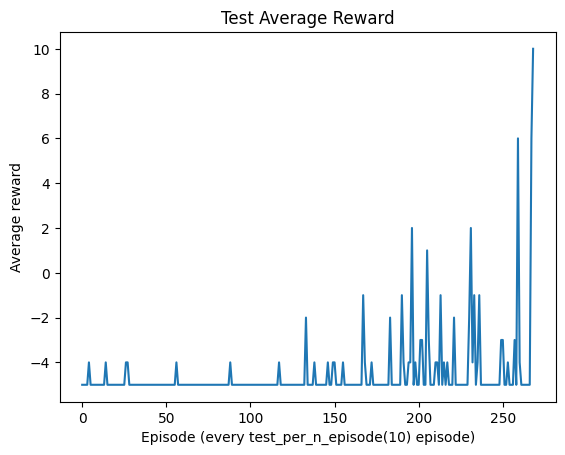

In [15]:
plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.title('Test Average Reward')
plt.xlabel('Episode (every test_per_n_episode(10) episode)')
plt.ylabel('Average reward')
plt.show()

# REPORT

在這次實驗中，我們使用了 **Actor-Critic** 神經網路架構來進行強化學習。這種架構的核心是由幾個主要部分組成：

1. **特徵提取器 (Feature Extractor)**：我們利用卷積層 (Conv2D) 來處理圖像輸入，提取環境中的空間特徵。這些卷積層後會將提取到的特徵進行展平，並映射到一個隱藏層。

2. **Actor Network**：根據特徵提取器的輸出，這一部分會生成一個動作分佈 (action logits)，並使用 softmax 函數來輸出每個動作的機率。

3. **Critic Network**：這部分同樣使用特徵提取器的輸入，但它的目標是生成一個價值預測，表示當前狀態的預期回報 (value)。

在這段代碼中，我們使用 **PPO (Proximal Policy Optimization)** 演算法，這是一種基於 Actor-Critic 架構的策略優化方法。為了提升訓練穩定性，我們結合了 **GAE (Generalized Advantage Estimation)** 來估算回報，進而準確地更新策略。

在 `ppo_update` 函數中，我們使用了 **剪切策略**，這樣可以限制每次策略更新的幅度，避免過大的調整，從而保持訓練過程中的穩定性。同時，通過計算 Actor 和 Critic 的損失來優化整體模型。

`compute_gae` 函數則負責計算每個時間步的優勢 (advantage)，幫助我們更精確地估算回報。

---

### 實驗過程與結果

這次的訓練跑了將近 **2700** 個 episode，才達到標準。從體感上來說，訓練時間真的很長，差不多花了 **10 多小時**，而且從訓練過程中的輸出來看，只有一個管子成功了。特別是當訓練進行到約 **2600** 個 episode 時，感覺模型的表現還差很多，但在接近 **2700** 時，突然情況大有改變，模型的表現顯著提升，達到了預期效果。


